In [1]:
import torch
import torchvision
import numpy as np
import cv2
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

## Importing MNIST dataset and creating train and test loder

In [2]:
n_epochs = 5
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
momentum = 0.5
log_interval = 10

random_seed = 1
torch.backends.cudnn.enabled = True
torch.manual_seed(random_seed)

train_loader = torch.utils.data.DataLoader(
  #torchvision.datasets.MNIST('/files/', train=True, download=True,
  torchvision.datasets.MNIST('.', train=True, download=True,

                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_train,pin_memory = True, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  #torchvision.datasets.MNIST('/files/', train=False, download=True,
  torchvision.datasets.MNIST('.', train=False, download=True,

                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=batch_size_test, pin_memory = True,shuffle=True)

#torchvision.transforms.Normalize(                                 (0.1307,), (0.3081,))

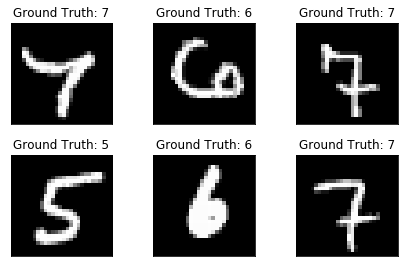

In [3]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
example_data.shape

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])


In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.mnist = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3),
            nn.BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Conv2d(16, 20, kernel_size=5),
            nn.BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(),
            nn.Dropout2d(),
            nn.Flatten(),
            nn.Linear(320, 50),
            nn.BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.ReLU(),
            nn.Linear(50, 10),
            nn.LogSoftmax()
        )

    def forward(self, x):
        x = self.mnist(x)
        return x


In [5]:
network_cpu = Net()
network = network_cpu.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [6]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = network(data.cuda())
        loss = F.nll_loss(output, target.cuda())
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
            torch.save(network.state_dict(), 'model.pth')
            torch.save(optimizer.state_dict(), 'optimizer.pth')
def test():
    network.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = network(data.cuda())
            test_loss += F.nll_loss(output, target.cuda(), size_average=False).item()
            #test_loss += F.nll_loss(output, target, size_average=False).item()

            pred = output.data.max(1, keepdim=True)[1]
            #correct += pred.eq(target.data.view_as(pred)).sum()
            correct += pred.cpu().eq(target.data.view_as(pred.cpu())).sum()
            test_loss /= len(test_loader.dataset)
            test_losses.append(test_loss)
            print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
                test_loss, correct, len(test_loader.dataset),
                100. * correct / len(test_loader.dataset)))

In [8]:
#Network training
for epoch in range(1, n_epochs + 1):
    train(epoch)
    test()

C:\Users\crsum\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.383272
Train Epoch: 1 [640/60000 (1%)]	Loss: 2.304424
Train Epoch: 1 [1280/60000 (2%)]	Loss: 2.208299
Train Epoch: 1 [1920/60000 (3%)]	Loss: 2.146656
Train Epoch: 1 [2560/60000 (4%)]	Loss: 2.014208
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.935144
Train Epoch: 1 [3840/60000 (6%)]	Loss: 1.930165
Train Epoch: 1 [4480/60000 (7%)]	Loss: 1.761986
Train Epoch: 1 [5120/60000 (9%)]	Loss: 1.739454
Train Epoch: 1 [5760/60000 (10%)]	Loss: 1.647626
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.554630
Train Epoch: 1 [7040/60000 (12%)]	Loss: 1.441419
Train Epoch: 1 [7680/60000 (13%)]	Loss: 1.401727
Train Epoch: 1 [8320/60000 (14%)]	Loss: 1.434840
Train Epoch: 1 [8960/60000 (15%)]	Loss: 1.364717
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.344824
Train Epoch: 1 [10240/60000 (17%)]	Loss: 1.231810
Train Epoch: 1 [10880/60000 (18%)]	Loss: 1.212245
Train Epoch: 1 [11520/60000 (19%)]	Loss: 1.075095
Train Epoch: 1 [12160/60000 (20%)]	Loss: 1.151920
Train Epoch: 1 [12800/60000 (

C:\Users\crsum\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0199, Accuracy: 955/10000 (10%)


Test set: Avg. loss: 0.0197, Accuracy: 1911/10000 (19%)


Test set: Avg. loss: 0.0171, Accuracy: 2864/10000 (29%)


Test set: Avg. loss: 0.0226, Accuracy: 3803/10000 (38%)


Test set: Avg. loss: 0.0191, Accuracy: 4760/10000 (48%)


Test set: Avg. loss: 0.0205, Accuracy: 5709/10000 (57%)


Test set: Avg. loss: 0.0173, Accuracy: 6669/10000 (67%)


Test set: Avg. loss: 0.0178, Accuracy: 7624/10000 (76%)


Test set: Avg. loss: 0.0185, Accuracy: 8583/10000 (86%)


Test set: Avg. loss: 0.0202, Accuracy: 9533/10000 (95%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.270019
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.452026
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.345250
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.352904
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.242325
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.324380
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.387620
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.380462
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.

Train Epoch: 3 [31360/60000 (52%)]	Loss: 0.231598
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.106008
Train Epoch: 3 [32640/60000 (54%)]	Loss: 0.200345
Train Epoch: 3 [33280/60000 (55%)]	Loss: 0.217677
Train Epoch: 3 [33920/60000 (57%)]	Loss: 0.090268
Train Epoch: 3 [34560/60000 (58%)]	Loss: 0.234017
Train Epoch: 3 [35200/60000 (59%)]	Loss: 0.196010
Train Epoch: 3 [35840/60000 (60%)]	Loss: 0.126041
Train Epoch: 3 [36480/60000 (61%)]	Loss: 0.119188
Train Epoch: 3 [37120/60000 (62%)]	Loss: 0.240342
Train Epoch: 3 [37760/60000 (63%)]	Loss: 0.194373
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.149166
Train Epoch: 3 [39040/60000 (65%)]	Loss: 0.154965
Train Epoch: 3 [39680/60000 (66%)]	Loss: 0.418261
Train Epoch: 3 [40320/60000 (67%)]	Loss: 0.269169
Train Epoch: 3 [40960/60000 (68%)]	Loss: 0.163501
Train Epoch: 3 [41600/60000 (69%)]	Loss: 0.129065
Train Epoch: 3 [42240/60000 (70%)]	Loss: 0.215807
Train Epoch: 3 [42880/60000 (71%)]	Loss: 0.186316
Train Epoch: 3 [43520/60000 (72%)]	Loss: 0.132331


Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.240178
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.227432
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.173642
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.180944
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.069482
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.114001
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.190454
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.212168
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.082159
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.129938
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.132226
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.175339
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.179772
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.218103
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.067516
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.102896
Train Epoch: 5 [12160/60000 (20%)]	Loss: 0.139666
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.108474
Train Epoch: 5 [13440/60000 (22%)]	Loss: 0.133580
Train Epoch: 5 [14080/60000 (23%)]	Loss: 0.092932
Train Epoch: 5 [147

In [7]:
saved_weights = torch.load('model.pth')

saved_model = Net()
saved_model = saved_model
saved_model = saved_model.cuda()

saved_model.load_state_dict(saved_weights)
saved_model.eval()
print(saved_model)

#input_image = cv2.imread('temp_folder/img_137.jpg',0)/255#example_data[2][0]
#input_tensor = torch.tensor(input_image[np.newaxis,np.newaxis,:,:],dtype=torch.float32)
#print(input_tensor)
#output = saved_model(input_tensor.cuda())
#print(output)

Net(
  (mnist): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (3): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
    (6): Dropout2d(p=0.5, inplace=False)
    (7): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
    (8): BatchNorm2d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): ReLU()
    (11): Dropout2d(p=0.5, inplace=False)
    (12): Flatten()
    (13): Linear(in_features=320, out_features=50, bias=True)
    (14): BatchNorm1d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): ReLU()
    (16): Linear(in_features=50, out_features=10, bias=True)
    (17): LogSoftmax()
  )
)


In [5]:
input_image = cv2.imread('temp_folder/img_137.jpg',0)/255#example_data[2][0]
input_tensor = torch.tensor(input_image[np.newaxis,np.newaxis,:,:],dtype=torch.float32)
#print(input_tensor)
output = saved_model(input_tensor.cuda())
print(output)

tensor([[-1.3734e+01, -1.4056e+01, -1.2564e+01, -4.4823e-05, -1.4061e+01,
         -1.0290e+01, -1.5320e+01, -1.3507e+01, -1.3215e+01, -1.3779e+01]],
       device='cuda:0', grad_fn=<LogSoftmaxBackward>)


C:\Users\crsum\Anaconda3\envs\pytorch\lib\site-packages\torch\nn\modules\container.py:92: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [6]:
conv_layer_idx = [0,2,7]
relu_layer_idx = [1,5,10,15,16]
fc_layer_idx = [13,16]
batch_norm2d_idx = [3,8]
batch_norm1d_idx = [14]
max_pool_idx = [4,9]

In [7]:
def merge_batch_norm2d(conv_layer_idx, bn2d_idx):
    eps =1e-05
    conv_weight = saved_weights['mnist.'+str(conv_layer_idx)+'.weight']
    conv_bias = saved_weights['mnist.'+str(conv_layer_idx)+'.bias']
    bn2d_gamma = saved_weights['mnist.'+str(bn2d_idx)+'.weight']
    bn2d_beta = saved_weights['mnist.'+str(bn2d_idx)+'.bias']
    
    bn2d_mean = saved_weights['mnist.'+str(bn2d_idx)+'.running_mean']
    bn2d_var = saved_weights['mnist.'+str(bn2d_idx)+'.running_var']
    bn2d_var = torch.sqrt(bn2d_var + eps)
    print(conv_weight.shape)

    conv_weight = conv_weight.transpose(0,3)
    print(conv_weight.shape)
    #gamma = bn.weight
    #beta = bn.bias
    #mean = bn.running_mean
    #var = bn.running_var
    #eps =1e-05

    #var_sqrt = torch.sqrt(var + eps)

    #w = (self.weight * gamma.reshape(self.out_channels, 1, 1, 1)) / var_sqrt.reshape(self.out_channels, 1,1, 1)
    #b = ((self.bias - mean) * gamma) / var_sqrt + beta

    output_conv_weight = torch.mul(conv_weight, torch.div(bn2d_gamma, bn2d_var))
    #print(output_conv_weight.shape)
    output_conv_weight = output_conv_weight.transpose(0,3)
    conv_weight = conv_weight.transpose(0,3)
    output_conv_bias = torch.add(torch.mul((conv_bias-bn2d_mean), torch.div(bn2d_gamma,bn2d_var)),bn2d_beta)
    return output_conv_weight, output_conv_bias#, #output_conv_weight, 

def merge_batch_norm1d(fc_layer_idx, bn1d_idx):
    eps =1e-05

    fc_weight = saved_weights['mnist.'+str(fc_layer_idx)+'.weight']
    fc_bias = saved_weights['mnist.'+str(fc_layer_idx)+'.bias']
    bn1d_gamma = saved_weights['mnist.'+str(bn1d_idx)+'.weight']
    bn1d_beta = saved_weights['mnist.'+str(bn1d_idx)+'.bias']
    bn1d_mean = saved_weights['mnist.'+str(bn1d_idx)+'.running_mean']
    bn1d_var = saved_weights['mnist.'+str(bn1d_idx)+'.running_var']
    bn1d_var = torch.sqrt(bn1d_var + eps)
    fc_weight = fc_weight.transpose(0,1)
    output_fc_weight = torch.mul(fc_weight, torch.div(bn1d_gamma, bn1d_var))
    fc_weight = fc_weight.transpose(0,1)
    output_fc_weight = output_fc_weight.transpose(0,1)
    output_fc_bias = torch.add(torch.mul((fc_bias-bn1d_mean), torch.div(bn1d_gamma,bn1d_var)),bn1d_beta)
    return output_fc_weight, output_fc_bias

In [8]:
def output_list_fn(layers_list,data_loader,model):
    tensor_list = []
    output_dict = {}
    count =0
    for batch_idx, (data, _) in enumerate(data_loader):
        max_output_list =[]
        x = data.cpu()
        for idx,seq in enumerate(model):#.mnist):
            x = seq(x)
            if idx in layers_list:
                max_output_list.append(x) #intermediate_output#(torch.flatten(x)))
        #del data_cuda
        #torch.cuda.empty_cache()
        iter = 0
        if count == 0:
            tensor_list.append(data)
        else:
            tensor_list[iter] = torch.cat((tensor_list[iter],data),0)
        iter+=1   
        for idx in layers_list:
            if count == 0:
                tensor_list.append(max_output_list[iter-1])
            else:
                tensor_list[iter] = torch.cat((tensor_list[iter],max_output_list[iter-1]),0)
            iter+=1
        
        count +=1
    tensor_list[0] = torch.flatten(tensor_list[0]).detach().numpy()
    output_dict['input'] = tensor_list[0]
    iter =1
    for idx in layers_list:
        tensor_list[iter] = torch.flatten(tensor_list[iter]).detach().numpy()
        output_dict[str(idx)] = tensor_list[iter]
        iter+=1

    return output_dict

In [9]:
def output_list_fn_cuda(layers_list,data_loader,model):
    tensor_list = []
    output_dict = {}
    count =0
    for batch_idx, (data, _) in enumerate(data_loader):
        max_output_list =[]
        x = data.cuda()
        for idx,seq in enumerate(model):#.mnist):
            x = seq(x)
            if idx in layers_list:
                max_output_list.append(x.detach().cpu()) #intermediate_output#(torch.flatten(x)))
        #del data_cuda
        #torch.cuda.empty_cache()
        iter = 0
        if count == 0:
            tensor_list.append(data)
        else:
            tensor_list[iter] = torch.cat((tensor_list[iter],data.cpu()),0)
        iter+=1   
        for idx in layers_list:
            if count == 0:
                tensor_list.append(max_output_list[iter-1])
            else:
                tensor_list[iter] = torch.cat((tensor_list[iter],max_output_list[iter-1]),0)
            iter+=1
        
        count +=1
    tensor_list[0] = torch.flatten(tensor_list[0]).detach().numpy()
    output_dict['input'] = tensor_list[0]
    iter =1
    for idx in layers_list:
        tensor_list[iter] = torch.flatten(tensor_list[iter]).detach().numpy()
        output_dict[str(idx)] = tensor_list[iter]
        iter+=1
    
    
    return output_dict

    

In [10]:
relu_output_dict = output_list_fn_cuda(relu_layer_idx,train_loader,saved_model.mnist.cuda())

C:\Users\crsum\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


In [11]:
# print percentiles
relu_layers = [1,5,10,15,16]
percentile_99 = np.percentile(relu_output_dict['input'],99)
percentile_99_9 = np.percentile(relu_output_dict['input'],99.9)
percentile_99_99 = np.percentile(relu_output_dict['input'],99.99)
percentile_100 = np.percentile(relu_output_dict['input'],100)
print('99 percentile', percentile_99)
print('99.9 percentile', percentile_99_9)
print('99.99 percentile', percentile_99_99)
print('100 percentile', percentile_100)
percentile_dict = {}
percentile_dict['layer_input_99'] = percentile_99
percentile_dict['layer_input_99_9'] = percentile_99_9
percentile_dict['layer_input_99_99'] = percentile_99_99
percentile_dict['layer_input_100'] = percentile_100
for idx in relu_layers:
    percentile_99 = np.percentile(relu_output_dict[str(idx)],99)
    percentile_99_9 = np.percentile(relu_output_dict[str(idx)],99.9)
    percentile_99_99 = np.percentile(relu_output_dict[str(idx)],99.99)
    percentile_100 = np.percentile(relu_output_dict[str(idx)],100)
    percentile_dict['layer_'+str(idx)+'_99'] = percentile_99
    percentile_dict['layer_'+str(idx)+'_99_9'] = percentile_99_9
    percentile_dict['layer_'+str(idx)+'_99_99'] = percentile_99_99
    percentile_dict['layer_'+str(idx)+'_100'] = percentile_100

    print('99 percentile', percentile_99)
    print('99.9 percentile', percentile_99_9)
    print('99.99 percentile', percentile_99_99)

    print('100 percentile', percentile_100)

99 percentile 0.9960784316062927
99.9 percentile 1.0
99.99 percentile 1.0
100 percentile 1.0
99 percentile 0.657135131955144
99.9 percentile 0.816114008665096
99.99 percentile 0.9123463034689401
100 percentile 1.0883766412734985
99 percentile 2.936004161834717
99.9 percentile 3.583656788110737
99.99 percentile 4.141691210078903
100 percentile 6.034055233001709
99 percentile 2.37951397895813
99.9 percentile 2.841526761770279
99.99 percentile 3.1277217894553537
100 percentile 3.9231252670288086
99 percentile 2.923907430171963
99.9 percentile 3.579677352190019
99.99 percentile 4.048984072303735
100 percentile 4.745292663574219
99 percentile 10.84741925239563
99.9 percentile 12.236660329818786
99.99 percentile 13.058166522598256
100 percentile 14.453241348266602


In [12]:
def normalize_weight_bias(weight,bias,l1_out,l2_out):
    weight = torch.mul(weight,l1_out/l2_out)
    bias = torch.div(bias,l2_out)
    return weight,bias

In [13]:
conv1_weight = saved_weights['mnist.0.weight']
conv1_bias = saved_weights['mnist.0.bias']

conv2_weight, conv2_bias = merge_batch_norm2d(2,3)
conv3_weight, conv3_bias = merge_batch_norm2d(7,8)
fc1_weight,fc1_bias = merge_batch_norm1d(13,14)
fc2_weight = saved_weights['mnist.16.weight']
fc2_bias = saved_weights['mnist.16.bias']

snn_conv1_weight,snn_conv1_bias = normalize_weight_bias(conv1_weight,conv1_bias,percentile_dict['layer_input_99_9'],percentile_dict['layer_1_99_9'])
snn_conv2_weight,snn_conv2_bias = normalize_weight_bias(conv2_weight,conv2_bias,percentile_dict['layer_1_99_9'],percentile_dict['layer_5_99_9'])
snn_conv3_weight,snn_conv3_bias = normalize_weight_bias(conv3_weight,conv3_bias,percentile_dict['layer_5_99_9'],percentile_dict['layer_10_99_9'])
snn_fc1_weight,snn_fc1_bias = normalize_weight_bias(fc1_weight,fc1_bias,percentile_dict['layer_10_99_9'],percentile_dict['layer_15_99_9'])
snn_fc2_weight,snn_fc2_bias = normalize_weight_bias(fc2_weight,fc2_bias,percentile_dict['layer_15_99_9'],percentile_dict['layer_16_99_9'])



#print(snn_conv1_weight)

torch.Size([16, 8, 3, 3])
torch.Size([3, 8, 3, 16])
torch.Size([20, 16, 5, 5])
torch.Size([5, 16, 5, 20])


In [14]:
conv_layer_idx = [0,2,7]
relu_layer_idx = [1,5,10,15,16]
fc_layer_idx = [13,16]
batch_norm2d_idx = [3,8]
batch_norm1d_idx = [14]
max_pool_idx = [4,9]


In [15]:
train_batch_size = 2000
test_batch_size = 1000
snn_train_loader = torch.utils.data.DataLoader(
  #torchvision.datasets.MNIST('/files/', train=True, download=True,
  torchvision.datasets.MNIST('.', train=True, download=True,

                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=train_batch_size,pin_memory = False, shuffle=True)

snn_test_loader = torch.utils.data.DataLoader(
  #torchvision.datasets.MNIST('/files/', train=False, download=True,
  torchvision.datasets.MNIST('.', train=False, download=True,

                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])),
  batch_size=test_batch_size, pin_memory = False,shuffle=True)


In [16]:
train_size =0
for batch_idx, (data, target) in enumerate(snn_train_loader):
    train_size += data.shape[0]
print(train_size)

test_size =0
for batch_idx, (data, target) in enumerate(snn_test_loader):
    test_size += data.shape[0]
print(test_size)
    

60000
10000


In [20]:
## Data gen: Generate data and analyze how many time steps on an average is needed for someone to confirm the output
#spikenet_fc_1 = spiking_fc(1,snn_fc1_weight,snn_fc1_bias,1).cuda()
#spikenet_fc_2 = spiking_fc(1,snn_fc2_weight,snn_fc2_bias,1).cuda()
#spike_frame = torch.zeros_like(input_tensor)
#spike_pot = torch.zeros_like(input_tensor)
sp1_shape = snn_conv1_weight.shape
spikenet_1 = nn.Conv2d(sp1_shape[0],sp1_shape[1],kernel_size=sp1_shape[2]).cuda()
spikenet_1.weight = nn.Parameter(snn_conv1_weight)
spikenet_1.bias = nn.Parameter(snn_conv1_bias)
sp2_shape = snn_conv2_weight.shape
spikenet_2 = nn.Conv2d(sp2_shape[0],sp2_shape[1],kernel_size=sp2_shape[2]).cuda()
spikenet_2.weight = nn.Parameter(snn_conv2_weight)
spikenet_2.bias = nn.Parameter(snn_conv2_bias)
sp3_shape = snn_conv3_weight.shape
spikenet_3 = nn.Conv2d(sp3_shape[0],sp3_shape[1],kernel_size=sp3_shape[2]).cuda()
spikenet_3.weight = nn.Parameter(snn_conv3_weight)
spikenet_3.bias = nn.Parameter(snn_conv3_bias)
sp_fc1_shape = snn_fc1_weight.shape
spikenet_fc_1 = nn.Linear(sp_fc1_shape[0],sp_fc1_shape[1]).cuda()
spikenet_fc_1.weight = nn.Parameter(snn_fc1_weight)
spikenet_fc_1.bias = nn.Parameter(snn_fc1_bias)
sp_fc2_shape = snn_fc2_weight.shape
spikenet_fc_2 = nn.Linear(sp_fc2_shape[0],sp_fc2_shape[1]).cuda()
spikenet_fc_2.weight = nn.Parameter(snn_fc2_weight)
spikenet_fc_2.bias = nn.Parameter(snn_fc2_bias)
#max_pool2 = nn.MaxPool2d(2, stride=2).cuda()
#max_pool3 = nn.MaxPool2d(2, stride=2).cuda()
max_pool2 = nn.MaxPool2d(2,stride=2,return_indices=True).cuda()
max_unpool2 = nn.MaxUnpool2d(2, stride=2).cuda()
max_pool3 = nn.MaxPool2d(2,stride=2,return_indices=True).cuda()
max_unpool3 = nn.MaxUnpool2d(2, stride=2).cuda()

number_of_timesteps = 500 #1000
train_output_expected = np.zeros((train_size,1))
train_output_array = np.zeros((train_size,number_of_timesteps))

In [ ]:
## Running SNN on train data 

In [ ]:
number_of_timesteps = 500
test_output_expected = np.zeros((test_size,1))
test_output_array = np.zeros((test_size,number_of_timesteps))

for batch_idx, (data, target) in enumerate(snn_train_loader):
    #x = data np.zeros((1000,1000))
    start = batch_idx*train_batch_size
    end = batch_idx*train_batch_size + data.shape[0]
    test_output_expected[start:end,0] = target.detach().numpy()
    data = data.cuda()
    #print(data.shape)
    spike_pot = torch.zeros_like(data).detach()cuda()
    sp1_out = torch.zeros((data.shape[0],8,26,26)).detach().cuda()
    sp2_out = torch.zeros((data.shape[0],16,24,24)).detach().cuda()
    sp3_out = torch.zeros((data.shape[0],20,8,8)).detach().cuda()
    sp_fc1_out = torch.zeros((data.shape[0],50)).detach().cuda()
    sp_fc2_out = torch.zeros((data.shape[0],10)).detach().cuda()

    
    for i in range(number_of_timesteps):
        print(i)
        first_frame = True if i ==0 else False
        #x = spike_frame_mnist.reset_by_subtraction(input_tensor,first_frame)
            
        #spike_pot = torch.add(spike_pot, data)
        spike_pot.add_(data)

        spike_frame = torch.gt(spike_pot,1.0)*1.0
        spike_pot.sub_(spike_frame)
        sp1_out.add_(spikenet_1(spike_frame))
        sp2_in = torch.gt(sp1_out,1.0)*1.0
        sp1_out.sub_(sp2_in)
        sp2_out.add_(spikenet_2(sp2_in))
        sp3_in = torch.gt(sp2_out,1.0)*1.0
        sp2_out.sub_(sp3_in)
        sp3_in_red = max_pool2(sp3_in)
        sp3_out.add_(spikenet_3(sp3_in_red))
        sp4_in = torch.gt(sp3_out,1.0)*1.0
        sp3_out.sub_(sp4_in)
        sp4_in_red = max_pool3(sp4_in)
        sp4_in_red_flat = torch.flatten(sp4_in_red,start_dim=1)
        sp_fc1_out.add_(spikenet_fc_1(sp4_in_red_flat))
        sp_fc2_in = torch.gt(sp_fc1_out,1.0)*1.0
        sp_fc1_out.sub_(sp_fc2_in)
        sp_fc2_out.add_(spikenet_fc_2(sp_fc2_in))
        sof_pot = F.softmax(sp_fc2_out)
        max_numbers = torch.argmax(sof_pot,dim=1)
        test_output_array[start:end,i] = max_numbers.cpu().detach().numpy()
        
        torch.cuda.empty_cache()
    torch.cuda.empty_cache()


In [21]:
def conv_layer_for_snn_pool(num_inp_ch):
    conv = nn.Conv2d(num_inp_ch,num_inp_ch,kernel_size=2,padding=0,stride=2).cuda()
    weight = torch.zeros((num_inp_ch,num_inp_ch,2,2)).cuda()
    for i in range(num_inp_ch):
        weight[i,i,:,:].add_(1.0)
    bias = torch.zeros(num_inp_ch).cuda()
    conv.weight = nn.Parameter(weight)
    conv.bias = nn.Parameter(bias)
    return conv

In [ ]:
def cnn2gemm(input_frame,kernel_size,padding=True):
    input_shape = input_frame.shape
    output_shape = input_frame.shape
    input_frame_tmp = None
    padding = (kernel_size+1)//2
    if not padding:
        output_shape[2] -= padding
        output_shape[3] -= padding
    input_frame_tmp= np.zeros((*output_shape),dtype= np.float32)
    
    if padding:
        input_frame_tmp[:,:,(padding//2):-(padding//2),(padding//2):-(padding//2)] = input_frame
    output_array = np.zeros((output_shape[1]*kernel_size*kernel_size,output_shape[2]*output_shape[3]),dtype= np.float32)
    
    
    

In [ ]:
## Running SNN on test data 

In [26]:
### RAM PLEASE LOOK AT THIS CODE

number_of_timesteps = 400
sp2_pool_conv = conv_layer_for_snn_pool(16)
sp3_pool_conv = conv_layer_for_snn_pool(20)

test_output_expected = np.zeros((test_size,1))
test_output_array = np.zeros((test_size,number_of_timesteps))
for batch_idx, (data, target) in enumerate(snn_test_loader):
    start = batch_idx*test_batch_size
    end = batch_idx*test_batch_size + data.shape[0]
    test_output_expected[start:end,0] = target.detach().numpy()
    data = data.cuda()
    spike_pot = torch.zeros_like(data).detach().cuda()
    sp1_np = np.zeros((data.shape[0],8,26,26))
    sp1_out = torch.tensor(sp1_np, requires_grad=False, dtype=torch.float32).cuda()
    sp2_np = np.zeros((data.shape[0],16,24,24))
    sp2_out = torch.tensor(sp2_np, requires_grad=False, dtype=torch.float32).cuda()
    sp2_pool = torch.tensor(sp2_np, requires_grad=False, dtype=torch.float32).cuda()
    sp2_unpool = torch.tensor(sp2_np, requires_grad=False, dtype=torch.float32).cuda()
    sp3_np = np.zeros((data.shape[0],20,8,8))
    sp3_out = torch.tensor(sp3_np, requires_grad=False, dtype=torch.float32).cuda()
    sp3_pool = torch.tensor(sp3_np, requires_grad=False, dtype=torch.float32).cuda()
    sp3_unpool = torch.tensor(sp3_np, requires_grad=False, dtype=torch.float32).cuda()
    sp_fc1_np = np.zeros((data.shape[0],50))
    sp_fc1_out = torch.tensor(sp_fc1_np, requires_grad=False, dtype=torch.float32).cuda()
    sp_fc2_np = np.zeros((data.shape[0],10))
    sp_fc2_out = torch.tensor(sp_fc2_np, requires_grad=False, dtype=torch.float32).cuda()
    print(batch_idx)
    for i in range(number_of_timesteps):
        #print(i)
        first_frame = True if i ==0 else False
        spike_pot.add_(data)

        spike_frame = torch.gt(spike_pot,1.0)*1.0 #F.threshold_(spike_pot,1,0).sign() #
        spike_pot.sub_(spike_frame)
        sp1_out.add_(spikenet_1(spike_frame).detach())
        sp2_in = torch.gt(sp1_out,1.0)*1.0 #F.threshold_(sp1_out, 1, 0) #
        sp1_out.sub_(sp2_in)
        sp2_out.add_(spikenet_2(sp2_in).detach())
        sp3_in = torch.gt(sp2_out,1.0)*1.0 #F.threshold_(sp2_out, 1, 0).sign() # 
        sp2_out.sub_(sp3_in)
        sp2_pool.add_(sp3_in)
        sp2_pool_out = max_pool2(sp2_pool)
        sp2_unpool_out = max_unpool2(*sp2_pool_out)
        sp2_pool_non_zero = (sp2_unpool_out != 0)*1.0
        sp3_in_masked = torch.mul(sp3_in,sp2_pool_non_zero)
        sp3_in_red = sp2_pool_conv(sp3_in_masked)
        #sp3_in_red = max_pool2(sp3_in)
        sp3_out.add_(spikenet_3(sp3_in_red).detach())
        sp4_in = torch.gt(sp3_out,1.0)*1.0 #F.threshold_(sp3_out, 1, 0).sign() #
        sp3_out.sub_(sp4_in)
        sp3_pool.add_(sp4_in)
        sp3_pool_out = max_pool3(sp3_pool)
        sp3_unpool_out = max_unpool3(*sp3_pool_out)
        sp3_pool_non_zero = (sp3_unpool_out != 0)*1.0
        sp4_in_masked = torch.mul(sp4_in,sp3_pool_non_zero)
        sp4_in_red = sp3_pool_conv(sp4_in_masked)
        
        #sp4_in_red = max_pool3(sp4_in)
        sp4_in_red_flat = torch.flatten(sp4_in_red,start_dim=1)
        sp_fc1_out.add_(spikenet_fc_1(sp4_in_red_flat).detach())
        sp_fc2_in = torch.gt(sp_fc1_out,1.0)*1.0 #F.threshold_(sp_fc1_out, 1, 0).sign() #
        sp_fc1_out.sub_(sp_fc2_in)
        sp_fc2_out.add_(spikenet_fc_2(sp_fc2_in).detach())
        sof_pot = F.softmax(sp_fc2_out).detach()
        max_numbers = torch.argmax(sof_pot,dim=1)
        test_output_array[start:end,i] = max_numbers.cpu().detach().numpy()
        #print(torch.cuda.memory_allocated(device=0))
        torch.cuda.empty_cache()


0


C:\Users\crsum\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:66: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


1
2
3
4
5
6
7
8
9


In [27]:
torch.cuda.empty_cache()

In [28]:
accuracy_over_time = np.zeros(test_output_array.shape[1])
total_samples = test_output_array.shape[0]
from scipy import stats
for idx in range(test_output_array.shape[1]):
    part_of_output = test_output_array[:,0:idx+1]
    max_of_part = stats.mode(part_of_output,axis=1)[0]
    #print(max_of_part)
    percentage = np.sum(np.equal(max_of_part ,test_output_expected)*1.0)
    #print(percentage)
    accuracy_over_time[idx] = percentage*100/total_samples
    

In [30]:
print(accuracy_over_time)

[10.1  10.1  22.81 44.41 86.6  91.14 96.22 96.81 97.37 97.55 97.65 97.7
 97.86 97.85 97.9  97.91 97.95 97.98 97.99 98.03 98.05 98.08 98.09 98.07
 98.06 98.06 98.08 98.08 98.1  98.1  98.11 98.13 98.15 98.15 98.15 98.15
 98.14 98.14 98.15 98.16 98.17 98.17 98.15 98.15 98.14 98.13 98.13 98.13
 98.13 98.13 98.13 98.14 98.14 98.14 98.15 98.17 98.17 98.17 98.17 98.16
 98.16 98.16 98.16 98.16 98.17 98.18 98.18 98.2  98.19 98.2  98.2  98.2
 98.2  98.2  98.2  98.22 98.22 98.22 98.22 98.23 98.23 98.23 98.24 98.24
 98.24 98.24 98.24 98.24 98.24 98.24 98.24 98.24 98.24 98.24 98.23 98.22
 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21
 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21 98.21
 98.21 98.21 98.2  98.2  98.18 98.18 98.18 98.18 98.18 98.18 98.17 98.17
 98.17 98.17 98.17 98.17 98.17 98.17 98.17 98.16 98.16 98.16 98.16 98.16
 98.16 98.16 98.17 98.17 98.17 98.17 98.17 98.17 98.17 98.17 98.17 98.17
 98.16 98.16 98.16 98.16 98.16 98.16 98.16 98.16 98.1

In [ ]:
#print(output_array[199])
print(train_output_array.shape)
print(train_output_expected.shape)
print(test_output_array.shape)
print(test_output_expected.shape)

In [ ]:
class compute_analysis():
    def __init__(self,inp_ch, out_ch, padding='valid', filter_size=(3,3)):
        #super.init(compute_analysis,self).__init__()
        self.inp_ch = inp_ch
        self.out_ch = out_ch
        self.filter_size = filter_size
        self.padding = padding
        self.total_number_of_conv_ops = 0
        self.single_conv_ops =0 
        self.shape = None
        self.output_shape = np.zeros(2)
        self.first_ifmap = 1
        self.ifmap_sparsity_list = [] #torch.zeros(1)
        self.number_of_zero_ifmaps = 0
        self.number_of_nonzero_addtions =0
        self.layer_dict ={}
        self.sparsity_tensor = None
        self.conv_counter = nn.Conv2d(inp_ch,out_ch,kernel_size=filter_size).cuda()
        self.conv_weight = torch.zeros((out_ch,inp_ch,*filter_size),dtype= torch.float32)+1.0
        self.conv_bias = torch.zeros(out_ch)

        self.conv_counter.weight = nn.Parameter(self.conv_weight.cuda())
        self.conv_counter.bias = nn.Parameter(self.conv_bias.cuda())
        
    ## This will measure sparsity over input images    
    def crude_conv_analysis(self,input_frame,first_frame):
        if first_frame == True:
            self.shape = input_frame.shape
            shape = self.shape
            number_of_inp_pix = shape[0]*shape[1]*shape[2]*shape[3]
            if self.padding == 'valid':
                self.output_shape[0] = int(shape[2]-self.filter_size[0]+1)
                self.output_shape[1] = int(shape[3]-self.filter_size[1]+1)
            else:
                self.output_shape[0] = int(shape[2])
                self.output_shape[1] = int(shape[3])
            
            self.total_number_of_conv_ops = shape[0]*(self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*shape[1]#self.inp_ch
            self.single_conv_ops = (self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*self.inp_ch
            number_of_mult_in_conv_per_op = self.filter_size[0]*self.filter_size[1]*self.inp_ch
            for i in range(shape[0]):
                for j in range(shape[1]):
                    for id1 in range(int(self.output_shape[0])):
                        for id2 in range(int(self.output_shape[1])):
                            if self.first_ifmap == 1:
                                number_of_on_fields = torch.sum(input_frame[i,j,id1:id1+self.filter_size[0],id2:id2+self.filter_size[1]])
                                self.number_of_nonzero_addtions += number_of_on_fields*self.out_ch
                                if number_of_on_fields ==0:
                                    self.number_of_zero_ifmaps+=1
                                #print('before',self.ifmap_sparsity_list,torch.div(number_of_on_fields,number_of_mult_in_conv_per_op))
                                self.ifmap_sparsity_list.append(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op).detach().numpy().item(0))
                                #print('after',self.ifmap_sparsity_list)

                                #self.ifmap_sparsity_list.append(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op))
                                #print(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op))#self.ifmap_sparsity_list)
                                self.first_ifmap = 0
                            else:
                                number_of_on_fields = torch.sum(input_frame[i,j,id1:id1+self.filter_size[0],id2:id2+self.filter_size[1]])
                                self.number_of_nonzero_addtions += number_of_on_fields*self.out_ch
                                if number_of_on_fields ==0:
                                    self.number_of_zero_ifmaps+=1
                                #print(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op))#self.ifmap_sparsity_list)
                                #print('before',self.ifmap_sparsity_list)

                                self.ifmap_sparsity_list.append(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op).detach().numpy().item(0))
                                #print('after',self.ifmap_sparsity_list)

                                #self.ifmap_sparsity_list = torch.cat((self.ifmap_sparsity_list[0],torch.div(number_of_on_fields,number_of_mult_in_conv_per_op)),0)
        
        else:
            self.shape = input_frame.shape
            shape = self.shape
            number_of_inp_pix = shape[0]*shape[1]*shape[2]*shape[3]

            self.total_number_of_conv_ops += shape[0]*(self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*shape[1]#self.inp_ch
            number_of_mult_in_conv_per_op = self.filter_size[0]*self.filter_size[1]*self.inp_ch
            for i in range(shape[0]):
                for j in range(shape[1]):
                    for id1 in range(int(self.output_shape[0])):
                        for id2 in range(int(self.output_shape[1])):
                            number_of_on_fields = torch.sum(input_frame[i,j,id1:id1+self.filter_size[0],id2:id2+self.filter_size[1]])
                            self.number_of_nonzero_addtions += number_of_on_fields*self.out_ch
                            if number_of_on_fields ==0:
                                self.number_of_zero_ifmaps+=1
                            #print(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op))#self.ifmap_sparsity_list)
                            #self.ifmap_sparsity_list = torch.cat((self.ifmap_sparsity_list,torch.div(number_of_on_fields,number_of_mult_in_conv_per_op)),0)
                            self.ifmap_sparsity_list.append(torch.div(number_of_on_fields,number_of_mult_in_conv_per_op).detach().numpy().item(0))

                            #self.ifmap_sparsity_list = torch.cat((self.ifmap_sparsity_list[0],torch.div(number_of_on_fields,number_of_mult_in_conv_per_op)),0)
                            
        

            
        return 0
    def conv_analysis(self,input_frame,first_frame):
        if first_frame == True:
            self.shape = input_frame.shape
            shape = self.shape
            number_of_inp_pix = shape[0]*shape[1]*shape[2]*shape[3]
            if self.padding == 'valid':
                self.output_shape[0] = int(shape[2]-self.filter_size[0]+1)
                self.output_shape[1] = int(shape[3]-self.filter_size[1]+1)
            else:
                self.output_shape[0] = int(shape[2])
                self.output_shape[1] = int(shape[3])

            self.total_number_of_conv_ops = shape[0]*(self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*shape[1]#self.inp_ch
            self.single_conv_ops = (self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*self.inp_ch
            number_of_mult_in_conv_per_op = self.filter_size[0]*self.filter_size[1]*self.inp_ch*self.out_ch
            #self.hist_bins = np.arange(number_of_mult_in_conv_per_op+1)
            number_of_on_fields = self.conv_counter(input_frame).detach().cpu()
            self.sparsity_tensor= torch.histc(number_of_on_fields,bins = number_of_mult_in_conv_per_op+1,max = number_of_mult_in_conv_per_op,min=0)
            self.number_of_nonzero_addtions += torch.sum(number_of_on_fields).detach().item()
            self.number_of_zero_ifmaps += torch.sum(torch.eq(number_of_on_fields,0)*1.0).detach().item()
            #self.sparsity_tensor = number_of_on_fields
            #self.sparsity_tensor = torch.div(number_of_on_fields,number_of_mult_in_conv_per_op).detach()
        
        else:
            self.shape = input_frame.shape
            shape = self.shape
            number_of_inp_pix = shape[0]*shape[1]*shape[2]*shape[3]

            self.total_number_of_conv_ops += shape[0]*(self.output_shape[0])*(self.output_shape[1])*self.out_ch*self.filter_size[0]*self.filter_size[1]*shape[1]#self.inp_ch
            number_of_mult_in_conv_per_op = self.filter_size[0]*self.filter_size[1]*self.inp_ch*self.out_ch
            number_of_on_fields = self.conv_counter(input_frame).detach().cpu()
            self.number_of_nonzero_addtions += torch.sum(number_of_on_fields).detach().item()
            self.number_of_zero_ifmaps += torch.sum(torch.eq(number_of_on_fields,0)*1.0).detach().item()
            self.sparsity_tensor.add_(torch.histc(number_of_on_fields,bins = number_of_mult_in_conv_per_op+1,max = number_of_mult_in_conv_per_op,min=0))

            #self.sparsity_tensor = torch.cat((self.sparsity_tensor,number_of_on_fields),0)
            #self.sparsity_tensor = torch.cat((self.sparsity_tensor,torch.div(number_of_on_fields,number_of_mult_in_conv_per_op).detach()),0)

            
        return 0
    
    
    
    def summary(self):
        self.layer_dict  = {'total_pure_ann_ops':self.total_number_of_conv_ops, 'single_ann_ops':self.single_conv_ops, 'ifmap_sparsity_list':self.ifmap_sparsity_list,'number_of_zero_ifmaps':self.number_of_zero_ifmaps,'total_nonzero_ops':self.number_of_nonzero_addtions,'sparsity_tensor':torch.flatten(self.sparsity_tensor)}
        return self.layer_dict
        
        
    def fc_analysis(self,input_frame):
        return 0

        
        

In [ ]:
number_of_timesteps = 200
conv1_analysis = compute_analysis(1, 8)
conv2_analysis = compute_analysis(8, 16)
conv3_analysis = compute_analysis(16, 20,(5,5))
test_output_expected = np.zeros((test_size,1))
test_output_array = np.zeros((test_size,number_of_timesteps))
for batch_idx, (data, target) in enumerate(snn_test_loader):
    start = batch_idx*train_batch_size
    end = batch_idx*train_batch_size + data.shape[0]
    data = data.cuda()
    
    spike_pot = torch.zeros_like(data).detach().cuda()
    sp1_np = np.zeros((data.shape[0],8,26,26))
    sp1_out = torch.tensor(sp1_np, requires_grad=False, dtype=torch.float32).cuda()
    sp2_np = np.zeros((data.shape[0],16,24,24))
    sp2_out = torch.tensor(sp2_np, requires_grad=False, dtype=torch.float32).cuda()
    sp3_np = np.zeros((data.shape[0],20,8,8))
    sp3_out = torch.tensor(sp3_np, requires_grad=False, dtype=torch.float32).cuda()
    sp_fc1_np = np.zeros((data.shape[0],50))
    sp_fc1_out = torch.tensor(sp_fc1_np, requires_grad=False, dtype=torch.float32).cuda()
    sp_fc2_np = np.zeros((data.shape[0],10))
    sp_fc2_out = torch.tensor(sp_fc2_np, requires_grad=False, dtype=torch.float32).cuda()
    
    for i in range(number_of_timesteps):
        #print(i)
        first_frame = True if i ==0 else False
        spike_pot.add_(data)

        spike_frame = torch.gt(spike_pot,1.0)*1.0 #F.threshold_(spike_pot,1,0).sign() #
        spike_pot.sub_(spike_frame)
        conv1_analysis.conv_analysis(spike_frame,first_frame)
        sp1_out.add_(spikenet_1(spike_frame).detach())
        sp2_in = torch.gt(sp1_out,1.0)*1.0 #F.threshold_(sp1_out, 1, 0) #
        sp1_out.sub_(sp2_in)
        conv2_analysis.conv_analysis(sp2_in,first_frame)

        sp2_out.add_(spikenet_2(sp2_in).detach())
        sp3_in = torch.gt(sp2_out,1.0)*1.0 #F.threshold_(sp2_out, 1, 0).sign() # 
        sp2_out.sub_(sp3_in)
        conv3_analysis.conv_analysis(sp3_in,first_frame)

        sp3_in_red = max_pool2(sp3_in)
        sp3_out.add_(spikenet_3(sp3_in_red).detach())
        sp4_in = torch.gt(sp3_out,1.0)*1.0 #F.threshold_(sp3_out, 1, 0).sign() #
        sp3_out.sub_(sp4_in)
        sp4_in_red = max_pool3(sp4_in)
        sp4_in_red_flat = torch.flatten(sp4_in_red,start_dim=1)
        sp_fc1_out.add_(spikenet_fc_1(sp4_in_red_flat).detach())
        sp_fc2_in = torch.gt(sp_fc1_out,1.0)*1.0 #F.threshold_(sp_fc1_out, 1, 0).sign() #
        sp_fc1_out.sub_(sp_fc2_in)
        sp_fc2_out.add_(spikenet_fc_2(sp_fc2_in).detach())
        sof_pot = F.softmax(sp_fc2_out).detach()
        max_numbers = torch.argmax(sof_pot,dim=1)
        print(torch.cuda.memory_allocated(device=0))
        torch.cuda.empty_cache()
    if(batch_idx==5):
        break
    else:
        print('batch_id', batch_idx)



print(conv1_analysis.summary())  
